# Ukraine Data Explorer

Source: [Humanitarian Data Exchange](https://data.humdata.org/visualization/ukraine-humanitarian-operations/)

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
import altair as alt
import urllib.request, json

In [4]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

---

## Parse data feed

In [5]:
all_url = (
    "https://raw.githubusercontent.com/OCHA-DAP/hdx-scraper-ukraine-viz/main/all.json"
)

#### Read data

In [6]:
import urllib.request, json

with urllib.request.urlopen(all_url) as url:
    data = json.loads(url.read().decode())
    print(data.keys())

dict_keys(['refugees_series_data', 'idps_macro_data', 'fatalities_data', 'regional_data', 'national_data', 'subnational_data', 'sources_data'])


#### Loop and create a list of dataframes

In [7]:
dataframes = []

for d in data.keys():
    dataframes.append(pd.DataFrame(data[d]))

#### Create dataframes for each data source

In [8]:
refugees_series_data = dataframes[0]
idps_macro_data = dataframes[1]
fatalities_data = dataframes[2]
national_data = dataframes[3]
subnational_data = dataframes[4]
sources_data = dataframes[5]

#### Clean up the column names

In [9]:
refugees_series_data.columns = refugees_series_data.columns.str.replace(
    "#", "", regex=False
).str.replace("+", "_", regex=False)
idps_macro_data.columns = idps_macro_data.columns.str.replace(
    "#", "", regex=False
).str.replace("+", "_", regex=False)
fatalities_data.columns = fatalities_data.columns.str.replace(
    "#", "", regex=False
).str.replace("+", "_", regex=False)
national_data.columns = national_data.columns.str.replace(
    "#", "", regex=False
).str.replace("+", "_", regex=False)
subnational_data.columns = subnational_data.columns.str.replace(
    "#", "", regex=False
).str.replace("+", "_", regex=False)
sources_data.columns = sources_data.columns.str.replace(
    "#", "", regex=False
).str.replace("+", "_", regex=False)

---

#### Refugees timeseries

In [10]:
refugees_series_data.head()

,affected_date_refugees,affected_refugees
0,2022-02-24,84681
1,2022-02-25,108301
2,2022-02-26,148319
3,2022-02-27,168364
4,2022-02-28,162474


#### Data types

In [11]:
refugees_series_data["date"] = pd.to_datetime(
    refugees_series_data["affected_date_refugees"]
)

In [12]:
refugees_series_data["affected_refugees"] = refugees_series_data[
    "affected_refugees"
].astype(int)

In [13]:
refugees_series_data["cumsum"] = refugees_series_data["affected_refugees"].cumsum()

In [14]:
alt.Chart(refugees_series_data).mark_line().encode(x="date", y="affected_refugees")

alt.Chart(...)

---

#### IDPS macro data feed

In [15]:
idps_macro_data.head()

,region_macro_name,affected_idps
0,KYIV,182672
1,EAST,1123237
2,SOUTH,417813
3,CENTER,1123237
4,NORTH,1044857


---

#### Fatality incidents

In [16]:
fatalities_data.head()

,date_occurred,event_type,event_type_sub,group_name_first,group_name_second,adm1_name,adm2_name,adm3_name,loc_name,geo_lat,geo_lon,description,affected_killed
0,2022-03-18,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),Civilians (Ukraine),Donetsk,Pokrovskyi,Avdiivska,Avdiivka,48.1394,37.7497,"On 18 March 2022, Russian forces fired Grad mi...",2
1,2022-03-18,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),Military Forces of Russia (2000-) Air Force,Kyiv,Buchanskyi,Buchanska,Bucha,50.5435,30.2120,"On 18 March 2022, Ukrainian air defense forces...",1
2,2022-03-18,Battles,Armed clash,Military Forces of Ukraine (2019-),Military Forces of Russia (2000-),Chernihiv,Chernihivskyi,Chepnigivska,Chernihiv,51.5055,31.2849,"On 18 March 2022, Ukrainian forces clashed wit...",0
3,2022-03-18,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Ukraine (2019-),Military Forces of Russia (2000-),Kherson,Khersonskyi,Chornobaivska,Chornobaivka,46.6974,32.5526,"On 18 March 2022, Ukrainian forces shelled the...",10
4,2022-03-18,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),Civilians (Ukraine),Kharkiv,Kharkivskyi,Kharkivska,Kharkiv,49.9808,36.2527,"On 18 March 2022, Russian forces fired missile...",1


#### Data types

In [17]:
fatalities_data["date_occurred"] = pd.to_datetime(fatalities_data["date_occurred"])
fatalities_data["affected_killed"] = fatalities_data["affected_killed"].astype(int)

#### Group by event types and total fatalities

In [18]:
fatalities_grouped = (
    fatalities_data.groupby(["date_occurred", "event_type", "event_type_sub"])
    .agg({"affected_killed": sum})
    .reset_index()
)

In [19]:
fatalities_grouped.head()

,date_occurred,event_type,event_type_sub,affected_killed
0,2022-02-24,Battles,Armed clash,51
1,2022-02-24,Battles,Non-state actor overtakes territory,0
2,2022-02-24,Explosions/Remote violence,Air/drone strike,0
3,2022-02-24,Explosions/Remote violence,Remote explosive/landmine/IED,0
4,2022-02-24,Explosions/Remote violence,Shelling/artillery/missile attack,19


In [20]:
fatalities_grouped.tail()

,date_occurred,event_type,event_type_sub,affected_killed
135,2022-03-17,Violence against civilians,Attack,4
136,2022-03-18,Battles,Armed clash,42
137,2022-03-18,Explosions/Remote violence,Air/drone strike,0
138,2022-03-18,Explosions/Remote violence,Shelling/artillery/missile attack,37
139,2022-03-18,Violence against civilians,Attack,1


#### Fatalities by type

In [21]:
fatalities_events_grouped = (
    fatalities_data.groupby(["date_occurred", "event_type"])
    .agg({"affected_killed": sum})
    .reset_index()
)

In [22]:
fatalities_events_pivot = (
    fatalities_events_grouped.pivot_table(
        columns="event_type", values="affected_killed", index="date_occurred"
    )
    .reset_index()
    .fillna(0)
)

In [23]:
fatalities_events_pivot

event_type,date_occurred,Battles,Explosions/Remote violence,Riots,Violence against civilians
0,2022-02-24,51.0,19.0,0.0,8.0
1,2022-02-25,20.0,13.0,0.0,3.0
2,2022-02-26,76.0,25.0,0.0,5.0
3,2022-02-27,30.0,13.0,0.0,16.0
4,2022-02-28,14.0,92.0,0.0,10.0
5,2022-03-01,12.0,67.0,0.0,5.0
6,2022-03-02,235.0,29.0,0.0,3.0
7,2022-03-03,54.0,68.0,0.0,3.0
8,2022-03-04,28.0,44.0,0.0,4.0
9,2022-03-05,82.0,27.0,0.0,5.0


#### Fatalities by more specific subtype

In [24]:
fatalities_subevents_grouped = (
    fatalities_data.groupby(["date_occurred", "event_type_sub"])
    .agg({"affected_killed": sum})
    .reset_index()
)

In [25]:
fatalities_subevents_pivot = (
    fatalities_subevents_grouped.pivot_table(
        columns="event_type_sub", values="affected_killed", index="date_occurred"
    )
    .reset_index()
    .fillna(0)
)

In [26]:
fatalities_subevents_pivot

event_type_sub,date_occurred,Abduction/forced disappearance,Air/drone strike,Armed clash,Attack,Government regains territory,Mob violence,Non-state actor overtakes territory,Remote explosive/landmine/IED,Shelling/artillery/missile attack
0,2022-02-24,0.0,0.0,51.0,8.0,0.0,0.0,0.0,0.0,19.0
1,2022-02-25,0.0,4.0,20.0,3.0,0.0,0.0,0.0,1.0,8.0
2,2022-02-26,0.0,0.0,76.0,5.0,0.0,0.0,0.0,0.0,25.0
3,2022-02-27,0.0,0.0,30.0,16.0,0.0,0.0,0.0,0.0,13.0
4,2022-02-28,0.0,0.0,13.0,10.0,0.0,0.0,1.0,1.0,91.0
5,2022-03-01,0.0,16.0,12.0,5.0,0.0,0.0,0.0,0.0,51.0
6,2022-03-02,0.0,18.0,235.0,3.0,0.0,0.0,0.0,0.0,11.0
7,2022-03-03,0.0,53.0,51.0,3.0,0.0,0.0,3.0,0.0,15.0
8,2022-03-04,0.0,34.0,28.0,4.0,0.0,0.0,0.0,0.0,10.0
9,2022-03-05,0.0,17.0,82.0,5.0,0.0,0.0,0.0,0.0,10.0


#### Fatalities over time

In [27]:
fatalities_timeseries = (
    fatalities_data.groupby(["date_occurred"])
    .agg({"affected_killed": sum})
    .reset_index()
)

In [28]:
fatalities_timeseries["cumsum"] = fatalities_timeseries["affected_killed"].cumsum()

In [29]:
fatalities_timeseries

,date_occurred,affected_killed,cumsum
0,2022-02-24,78,78
1,2022-02-25,36,114
2,2022-02-26,106,220
3,2022-02-27,59,279
4,2022-02-28,116,395
5,2022-03-01,84,479
6,2022-03-02,267,746
7,2022-03-03,125,871
8,2022-03-04,76,947
9,2022-03-05,114,1061


---

#### Civilian fatalities

In [30]:
subnational_data[["affected_idps", "affected_killed", "affected_injured"]] = (
    subnational_data[["affected_idps", "affected_killed", "affected_injured"]]
    .fillna(0)
    .astype(int)
)

In [31]:
subnational_data

,country_code,country_name,population,affected_idps,affected_killed,affected_injured,indicator_attacks_healthcare_num,indicator_attacks_education_num,inneed_ind,value_funding_other_plan_name,value_funding_other_required_usd,value_funding_other_total_usd,value_funding_other_pct,value_funding_uhf_usd,value_cerf_funding_total_usd,affected_refugees,affected_date_refugees
0,UKR,Ukraine,44134693,6477723,977,1594,64,518,12000000,Ukraine Flash Appeal 2022,1139900000,468549844,0.4110,86086787,60503889.0,NaN,NaN
1,POL,Poland,37950802,0,0,0,NaN,NaN,NaN,Ukraine Regional Refugee Response Plan 2022,NaN,47900000,NaN,NaN,NaN,2144244,2022-03-22
2,HUN,Hungary,9749763,0,0,0,NaN,NaN,NaN,Ukraine Regional Refugee Response Plan 2022,NaN,9300000,NaN,NaN,NaN,324397,2022-03-22
3,SVK,Slovakia,5458827,0,0,0,NaN,NaN,NaN,Ukraine Regional Refugee Response Plan 2022,NaN,3800000,NaN,NaN,NaN,256838,2022-03-22
4,ROU,Romania,19286123,0,0,0,NaN,NaN,NaN,Ukraine Regional Refugee Response Plan 2022,NaN,10300000,NaN,NaN,NaN,253771,2022-03-22
5,MDA,Republic of Moldova,2620495,0,0,0,NaN,NaN,NaN,Ukraine Regional Refugee Response Plan 2022,NaN,21570877,NaN,NaN,NaN,371104,2022-03-22
6,BLR,Belarus,9379952,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4938,2022-03-22
7,RUS,Russian Federation,144104080,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,271254,2022-03-22


In [32]:
killed = subnational_data[subnational_data["country_name"] == "Ukraine"][
    "affected_killed"
][0]
injured = subnational_data[subnational_data["country_name"] == "Ukraine"][
    "affected_injured"
][0]

In [33]:
injured

1594

In [34]:
killed

977

---

#### Population data 

In [35]:
sources_data.head()

,country_code,country_name,adm1_code,adm1_name,population,loc_count_health
0,UKR,Ukraine,UA01,Avtonomna Respublika Krym,1941905,144
1,UKR,Ukraine,UA71,Cherkaska,1188508,48
2,UKR,Ukraine,UA74,Chernihivska,982752,35
3,UKR,Ukraine,UA73,Chernivetska,898567,43
4,UKR,Ukraine,UA12,Dnipropetrovska,3173339,86


---

## Geography

#### Make the fatalities data a geodataframe

In [36]:
fatalities_data.head(1)

,date_occurred,event_type,event_type_sub,group_name_first,group_name_second,adm1_name,adm2_name,adm3_name,loc_name,geo_lat,geo_lon,description,affected_killed
0,2022-03-18,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Russia (2000-),Civilians (Ukraine),Donetsk,Pokrovskyi,Avdiivska,Avdiivka,48.1394,37.7497,"On 18 March 2022, Russian forces fired Grad mi...",2


#### Convert lon/lat

In [37]:
fatalities_data_gdf = gpd.GeoDataFrame(
    fatalities_data,
    geometry=gpd.points_from_xy(fatalities_data.geo_lon, fatalities_data.geo_lat),
)

<AxesSubplot:>

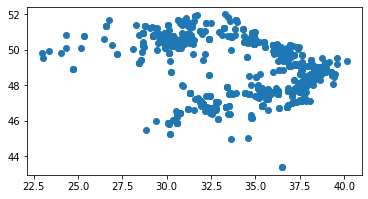

In [38]:
fatalities_data_gdf.plot()

In [39]:
border_crossings = gpd.read_file(
    "https://raw.githubusercontent.com/OCHA-DAP/hdx-scraper-ukraine-viz/main/UKR_Border_Crossings.geojson"
)

<AxesSubplot:>

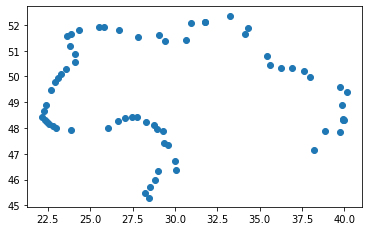

In [40]:
border_crossings.plot()

#### Regions

In [41]:
regions = gpd.read_file(
    "https://data.humdata.org/visualization/ukraine-humanitarian-operations/data/macro-region.geojson"
)

<AxesSubplot:>

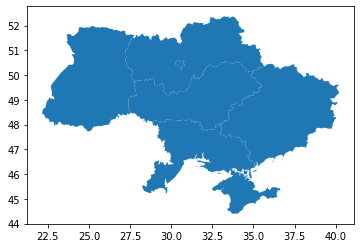

In [42]:
regions.plot()

---

#### Exports

In [43]:
refugees_series_data.to_csv(
    "data/processed/tracker_refugees_series_data.csv", index=False
)

In [44]:
fatalities_timeseries.to_csv(
    "data/processed/tracker_fatalities_timeseries.csv", index=False
)

In [45]:
fatalities_events_pivot.to_csv(
    "data/processed/tracker_incidents_fatalities_types.csv", index=False
)

In [46]:
fatalities_subevents_pivot.to_csv(
    "data/processed/tracker_subtype_incidents_fatalities_types.csv", index=False
)

In [47]:
fatalities_data_gdf.to_file(
    "data/processed/tracker_fatalities_locations.geojson", driver="GeoJSON"
)